### **SEMANTIC SEGMENTATION PORTFOLIO PROJECT**

**What is Semantic Segmentation?**

Semantic segmentation is an advanced computer vision technique that involves partitioning an image into distinct, semantically meaningful regions, where every pixel is classified into a specific object category. Unlike traditional image classification or object detection, which might only identify the presence of an object or provide bounding boxes, semantic segmentation assigns a label to each individual pixel, effectively “understanding” the image at a granular level.

At its core, semantic segmentation aims to provide a comprehensive understanding of the scene by differentiating between various objects and backgrounds. For example, in an autonomous driving scenario, a semantic segmentation system can distinguish roads, vehicles, pedestrians, trees, and buildings from one another. This pixel-level classification is critical for decision-making systems that require precise localization of objects in real time.

Deep learning, particularly convolutional neural networks (CNNs), has revolutionized the field of semantic segmentation. Architectures like Fully Convolutional Networks (FCNs) replaced traditional fully connected layers with convolutional layers to maintain spatial information, making them suitable for pixel-wise predictions. Later innovations, including models like U-Net, DeepLab, and SegNet, have introduced enhancements such as encoder-decoder frameworks and dilated convolutions. These improvements help capture both high-level context and fine-grained details by considering various scales of features without sacrificing resolution.

The training process for semantic segmentation models often relies on large, meticulously labeled datasets where every pixel is annotated. This pixel-level annotation is resource-intensive, prompting ongoing research into more efficient, weakly-supervised, and unsupervised methods to reduce the reliance on extensive manual labeling.

In summary, semantic segmentation is fundamental for applications requiring detailed scene understanding. By providing a comprehensive pixel-wise classification of images, it enables systems across various domains—from autonomous vehicles to medical imaging—to make informed and precise decisions based on complex visual inputs.

### **DATA SET**

**Aerial Semantic Segmentation Drone Dataset**

**About Dataset**

Dataset Resource: https://www.tugraz.at/index.php?id=22387

Citation

If you use this dataset in your research, please cite the following URL:

http://dronedataset.icg.tugraz.at

License
The Drone Dataset is made freely available to academic and non-academic entities for non-commercial purposes such as academic research, teaching, scientific publications, or personal experimentation. Permission is granted to use the data given that you agree:

That the dataset comes "AS IS", without express or implied warranty. Although every effort has been made to ensure accuracy, we (Graz University of Technology) do not accept any responsibility for errors or omissions.
That you include a reference to the Semantic Drone Dataset in any work that makes use of the dataset. For research papers or other media link to the Semantic Drone Dataset webpage.
That you do not distribute this dataset or modified versions. It is permissible to distribute derivative works in as far as they are abstract representations of this dataset (such as models trained on it or additional annotations that do not directly include any of our data) and do not allow to recover the dataset or something similar in character.
That you may not use the dataset or any derivative work for commercial purposes as, for example, licensing or selling the data, or using the data with a purpose to procure a commercial gain.
That all rights not expressly granted to you are reserved by us (Graz University of Technology).

Dataset Overview
The Semantic Drone Dataset focuses on semantic understanding of urban scenes for increasing the safety of autonomous drone flight and landing procedures. The imagery depicts more than 20 houses from nadir (bird's eye) view acquired at an altitude of 5 to 30 meters above ground. A high resolution camera was used to acquire images at a size of 6000x4000px (24Mpx). The training set contains 400 publicly available images and the test set is made up of 200 private images.

PERSON DETECTION
For the task of person detection the dataset contains bounding box annotations of the training and test set.

SEMANTIC SEGMENTATION
We prepared pixel-accurate annotation for the same training and test set. The complexity of the dataset is limited to 20 classes as listed in the following table.

Table 1: Semanic classes of the Drone Dataset

tree, gras, other vegetation, dirt, gravel, rocks, water, paved area, pool, person, dog, car, bicycle, roof, wall, fence, fence-pole, window, door, obstacle

### **PROJECT LIBRARIRES**

Importing Required Libraries

In [21]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [22]:
from PIL import Image
import cv2
import albumentations as A
import time
import os
from tqdm.notebook import tqdm

In [23]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary
import segmentation_models_pytorch as smp


# Set Device
# Automatically select CUDA if available for faster training.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### **PROCESING DATA**

Define the paths to the images and masks.

In [ ]:
IMAGE_PATH = '/Users/Michal/Desktop/ML/Imperial_College/Module_25/Portfolio_Project/Semantic_Segmentation/semantic_drone_dataset/original_images/'
MASK_PATH = '/Users/Michal/Desktop/ML/Imperial_College/Module_25/Portfolio_Project/Semantic_Segmentation/semantic_drone_dataset/label_images_semantic/'

Create DataFrame from Image Filenames

In [25]:
n_classes = 23 # Number of segmentation classes

def create_df():
    """Generates a DataFrame with image IDs from the image directory."""
    names = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            names.append(os.path.splitext(filename)[0])  # Use os.path.splitext for clarity
    return pd.DataFrame({'id': names})

df = create_df()
print('Total Images: ', len(df))

Total Images:  400


In [26]:
df

,id
0,162
1,176
2,348
3,406
4,412
...,...
395,345
396,386
397,153
398,147


Split Data into Training, Validation, and Test Sets

Using sklearn's train_test_split for reproducibility.

In [27]:
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  306
Val Size     :  54
Test Size    :  40


Visualize a Sample Image and its Corresponding Mask

Display one image and its mask to verify correctness.

Image Size: (4000, 6000, 3)
Mask Size: (4000, 6000)


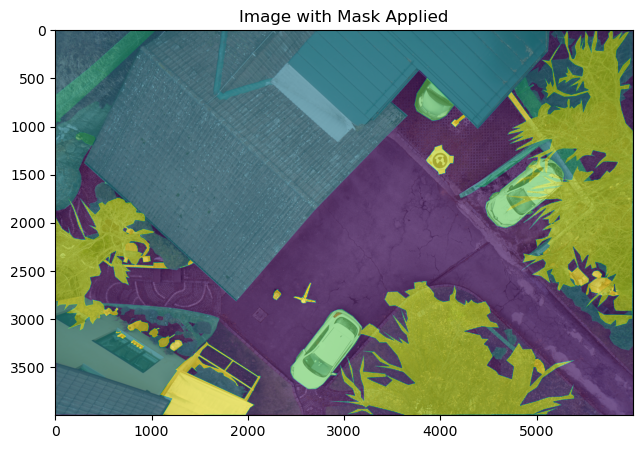

In [28]:
img = Image.open(os.path.join(IMAGE_PATH, df['id'][100] + '.jpg'))
mask = Image.open(os.path.join(MASK_PATH, df['id'][100] + '.png'))
print('Image Size:', np.asarray(img).shape)
print('Mask Size:', np.asarray(mask).shape)

plt.figure(figsize=(10, 5))
plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Image with Mask Applied')
plt.show()

### **DATASET**

Custom Dataset Class for Drone Data

In [29]:
class DroneDataset(Dataset):
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        """
        Args:
            img_path (str): Directory path for images.
            mask_path (str): Directory path for masks.
            X (list): List of image IDs.
            mean, std (list): Normalization parameters.
            transform (albumentations.Compose, optional): Augmentations to apply.
            patch (bool): If True, split images and masks into patches.
        """
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        # Construct full file paths
        img_file = os.path.join(self.img_path, self.X[idx] + '.jpg')
        mask_file = os.path.join(self.mask_path, self.X[idx] + '.png')
        
        # Read image and mask with error handling
        img = cv2.imread(img_file)
        if img is None:
            raise FileNotFoundError(f"Image not found: {img_file}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Mask not found: {mask_file}")
        
        # Apply augmentations if provided
        if self.transform is not None:
            augmented = self.transform(image=img, mask=mask)
            img = Image.fromarray(augmented['image'])
            mask = augmented['mask']
        else:
            img = Image.fromarray(img)
        
        # Convert image to tensor and normalize
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        # If patching is enabled, split image and mask into patches
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):
        """Splits the image and mask into patches using tensor unfold."""
        # Create patches from the image: adjust patch sizes as needed
        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches = img_patches.contiguous().view(3, -1, 512, 768)
        img_patches = img_patches.permute(1, 0, 2, 3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

Define Normalization Parameters and Augmentation Pipelines

In [30]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

t_train = A.Compose([
    A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),
    A.HorizontalFlip(), A.VerticalFlip(), 
    A.GridDistortion(p=0.2),
    A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.5),
    A.GaussNoise()
])

# For validation, consider using only resizing to avoid random augmentations
t_val = A.Compose([
    A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST)
])

Create Dataset Instances and DataLoaders

In [31]:
batch_size = 3 

train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, transform=t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, transform=t_val, patch=False)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

### **MODEL**

Define the Segmentation Model. Using a U-Net with MobileNetV2 as the backbone from segmentation_models_pytorch

In [32]:
model = smp.Unet(
    'mobilenet_v2', 
    encoder_weights='imagenet', 
    classes=n_classes, 
    activation=None, 
    encoder_depth=5, 
    decoder_channels=[256, 128, 64, 32, 16]
)

In [33]:
model

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

### **TRAINING**

Define Evaluation Metrics

In [34]:
def pixel_accuracy(output, mask):
    """Calculate pixel-wise accuracy."""
    with torch.no_grad():
        # Compute softmax and take argmax to obtain class predictions
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [35]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=n_classes):
    """Calculate Mean Intersection over Union (mIoU)."""
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(n_classes):  # Loop over each class
            true_class = pred_mask == clas
            true_label = mask == clas

            # If no pixels for this class in ground truth, skip IoU calculation
            if true_label.long().sum().item() == 0:
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()
                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [36]:
def get_lr(optimizer):
    """Retrieve the current learning rate from the optimizer."""
    for param_group in optimizer.param_groups:
        return param_group['lr']

# %% [markdown]
# ### Training Loop Function
def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    """
    Train the segmentation model and evaluate on the validation set.
    
    Args:
        epochs (int): Number of training epochs.
        model: The segmentation model.
        train_loader, val_loader: Data loaders for training and validation.
        criterion: Loss function.
        optimizer: Optimizer.
        scheduler: Learning rate scheduler.
        patch (bool): If True, process image patches.
        
    Returns:
        history (dict): Training history including losses, accuracies, and mIoU.
    """
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []
    val_acc = []
    train_iou = []
    train_acc = []
    lrs = []
    best_val_loss = np.inf  # Track the best validation loss
    epochs_no_improve = 0  # Early stopping counter

    model.to(device)
    fit_time = time.time()
    
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy_score = 0
        
        # Training phase
        model.train()
        for data in tqdm(train_loader, desc=f"Training Epoch {e+1}"):
            image_tiles, mask_tiles = data
            
            # If using patch mode, flatten the patches into a single batch
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()
                image_tiles = image_tiles.view(-1, c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device)
            mask = mask_tiles.to(device)
            
            # Forward pass
            output = model(image)
            loss = criterion(output, mask)
            
            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            # Evaluate metrics on the fly
            iou_score += mIoU(output, mask)
            accuracy_score += pixel_accuracy(output, mask)
            running_loss += loss.item()
            
            # Update learning rate scheduler per iteration
            lrs.append(get_lr(optimizer))
            scheduler.step()
        
        # Validation phase
        model.eval()
        test_loss = 0
        test_accuracy = 0
        val_iou_score = 0
        
        with torch.no_grad():
            for data in tqdm(val_loader, desc=f"Validation Epoch {e+1}"):
                image_tiles, mask_tiles = data
                if patch:
                    bs, n_tiles, c, h, w = image_tiles.size()
                    image_tiles = image_tiles.view(-1, c, h, w)
                    mask_tiles = mask_tiles.view(-1, h, w)
                
                image = image_tiles.to(device)
                mask = mask_tiles.to(device)
                
                output = model(image)
                loss = criterion(output, mask)
                test_loss += loss.item()
                test_accuracy += pixel_accuracy(output, mask)
                val_iou_score += mIoU(output, mask)
        
        # Calculate average metrics for the epoch
        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss = test_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        test_losses.append(avg_val_loss)
        train_iou.append(iou_score / len(train_loader))
        val_iou.append(val_iou_score / len(val_loader))
        train_acc.append(accuracy_score / len(train_loader))
        val_acc.append(test_accuracy / len(val_loader))
        
        # Early stopping & model checkpointing
        if avg_val_loss < best_val_loss:
            print(f'Validation loss decreased from {best_val_loss:.3f} to {avg_val_loss:.3f}. Saving model...')
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            # Save only the model state_dict (recommended over saving the full model)
            torch.save(model.state_dict(), f'Unet-Mobilenet_v2_mIoU-{val_iou_score/len(val_loader):.3f}.pt')
        else:
            epochs_no_improve += 1
            print(f'Validation loss did not decrease for {epochs_no_improve} consecutive epoch(s).')
            if epochs_no_improve == 7:
                print('Early stopping triggered: no improvement for 7 consecutive epochs.')
                break
        
        print(f"Epoch: {e+1}/{epochs} | Train Loss: {avg_train_loss:.3f} | Val Loss: {avg_val_loss:.3f} | " +
              f"Train mIoU: {iou_score/len(train_loader):.3f} | Val mIoU: {val_iou_score/len(val_loader):.3f} | " +
              f"Train Acc: {accuracy_score/len(train_loader):.3f} | Val Acc: {test_accuracy/len(val_loader):.3f} | " +
              f"Time: {(time.time()-since)/60:.2f}m")
        
    history = {
        'train_loss': train_losses,
        'val_loss': test_losses,
        'train_miou': train_iou,
        'val_miou': val_iou,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'lrs': lrs
    }
    print(f'Total training time: {(time.time()-fit_time)/60:.2f}m')
    return history

Set Hyperparameters and Initialize Training Components

In [37]:
max_lr = 1e-3
epoch = 8
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
# OneCycleLR scheduler steps on each batch
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch, steps_per_epoch=len(train_loader))


# Start Training
history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

Training Epoch 1:   0%|          | 0/102 [00:00<?, ?it/s]

Validation Epoch 1:   0%|          | 0/18 [00:00<?, ?it/s]

Validation loss decreased from inf to 1.851. Saving model...
Epoch: 1/8 | Train Loss: 2.509 | Val Loss: 1.851 | Train mIoU: 0.053 | Val mIoU: 0.089 | Train Acc: 0.346 | Val Acc: 0.512 | Time: 40.31m


Training Epoch 2:   0%|          | 0/102 [00:00<?, ?it/s]

Validation Epoch 2:   0%|          | 0/18 [00:00<?, ?it/s]

Validation loss decreased from 1.851 to 1.588. Saving model...
Epoch: 2/8 | Train Loss: 1.841 | Val Loss: 1.588 | Train mIoU: 0.073 | Val mIoU: 0.091 | Train Acc: 0.490 | Val Acc: 0.525 | Time: 48.55m


Training Epoch 3:   0%|          | 0/102 [00:00<?, ?it/s]

Validation Epoch 3:   0%|          | 0/18 [00:00<?, ?it/s]

Validation loss decreased from 1.588 to 1.316. Saving model...
Epoch: 3/8 | Train Loss: 1.698 | Val Loss: 1.316 | Train mIoU: 0.088 | Val mIoU: 0.128 | Train Acc: 0.511 | Val Acc: 0.663 | Time: 45.09m


Training Epoch 4:   0%|          | 0/102 [00:00<?, ?it/s]

Validation Epoch 4:   0%|          | 0/18 [00:00<?, ?it/s]

Validation loss did not decrease for 1 consecutive epoch(s).
Epoch: 4/8 | Train Loss: 1.558 | Val Loss: 1.326 | Train mIoU: 0.103 | Val mIoU: 0.129 | Train Acc: 0.545 | Val Acc: 0.602 | Time: 80.75m


Training Epoch 5:   0%|          | 0/102 [00:00<?, ?it/s]

Validation Epoch 5:   0%|          | 0/18 [00:00<?, ?it/s]

Validation loss decreased from 1.316 to 1.141. Saving model...
Epoch: 5/8 | Train Loss: 1.504 | Val Loss: 1.141 | Train mIoU: 0.115 | Val mIoU: 0.152 | Train Acc: 0.564 | Val Acc: 0.680 | Time: 165.59m


Training Epoch 6:   0%|          | 0/102 [00:00<?, ?it/s]

Validation Epoch 6:   0%|          | 0/18 [00:00<?, ?it/s]

Validation loss decreased from 1.141 to 1.012. Saving model...
Epoch: 6/8 | Train Loss: 1.437 | Val Loss: 1.012 | Train mIoU: 0.123 | Val mIoU: 0.166 | Train Acc: 0.576 | Val Acc: 0.711 | Time: 30.68m


Training Epoch 7:   0%|          | 0/102 [00:00<?, ?it/s]

Validation Epoch 7:   0%|          | 0/18 [00:00<?, ?it/s]

Validation loss decreased from 1.012 to 0.952. Saving model...
Epoch: 7/8 | Train Loss: 1.361 | Val Loss: 0.952 | Train mIoU: 0.127 | Val mIoU: 0.168 | Train Acc: 0.594 | Val Acc: 0.735 | Time: 95.52m


Training Epoch 8:   0%|          | 0/102 [00:00<?, ?it/s]

Validation Epoch 8:   0%|          | 0/18 [00:00<?, ?it/s]

Validation loss decreased from 0.952 to 0.927. Saving model...
Epoch: 8/8 | Train Loss: 1.307 | Val Loss: 0.927 | Train mIoU: 0.132 | Val mIoU: 0.171 | Train Acc: 0.615 | Val Acc: 0.733 | Time: 31.08m
Total training time: 537.58m


In [38]:
torch.save(model, 'Unet-Mobilenet_MS.pt')

In [39]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

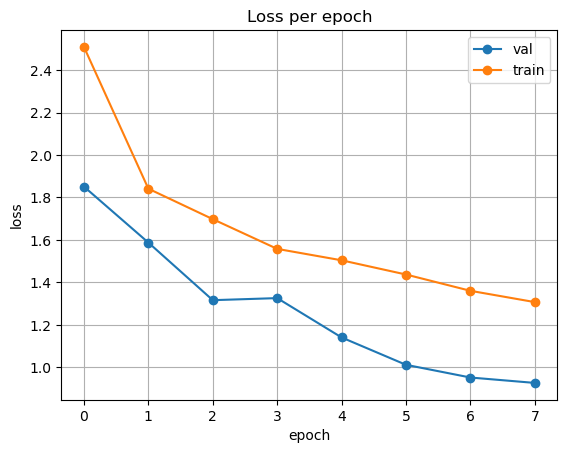

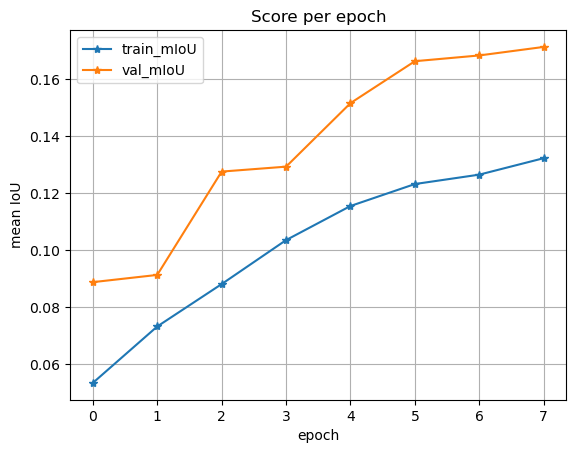

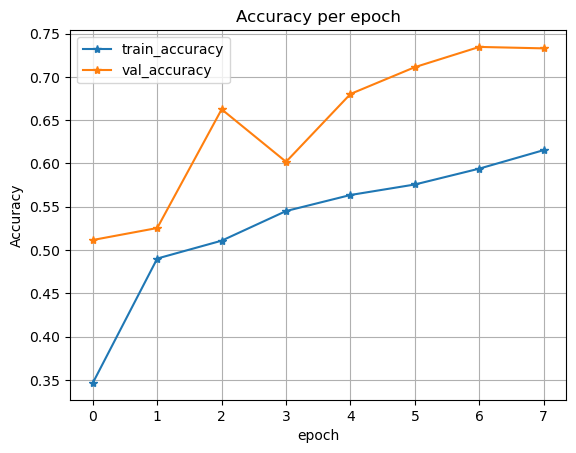

In [40]:
plot_loss(history)
plot_score(history)
plot_acc(history)

### **EVALUATION**

In [41]:
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

### **RESULT**

In [42]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [43]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [44]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [45]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [46]:
mob_miou = miou_score(model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

In [47]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [48]:
mob_acc = pixel_acc(model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

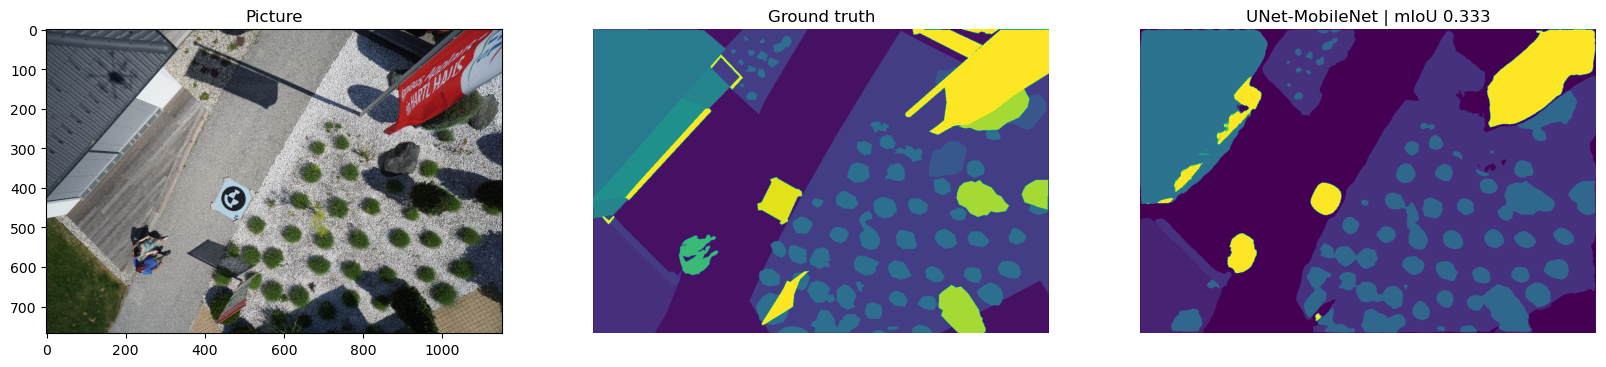

In [49]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

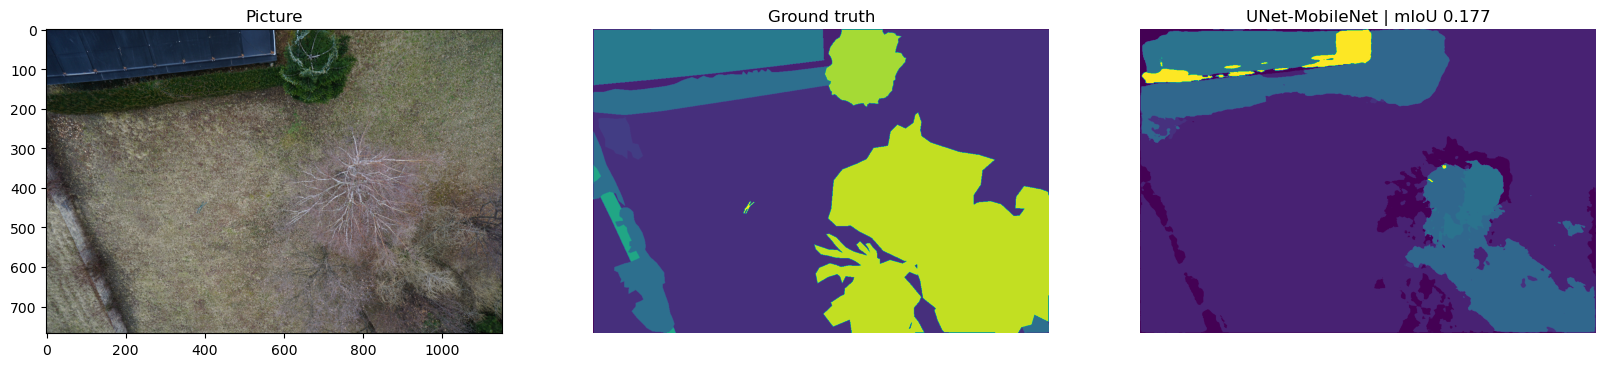

In [50]:
image2, mask2 = test_set[4]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

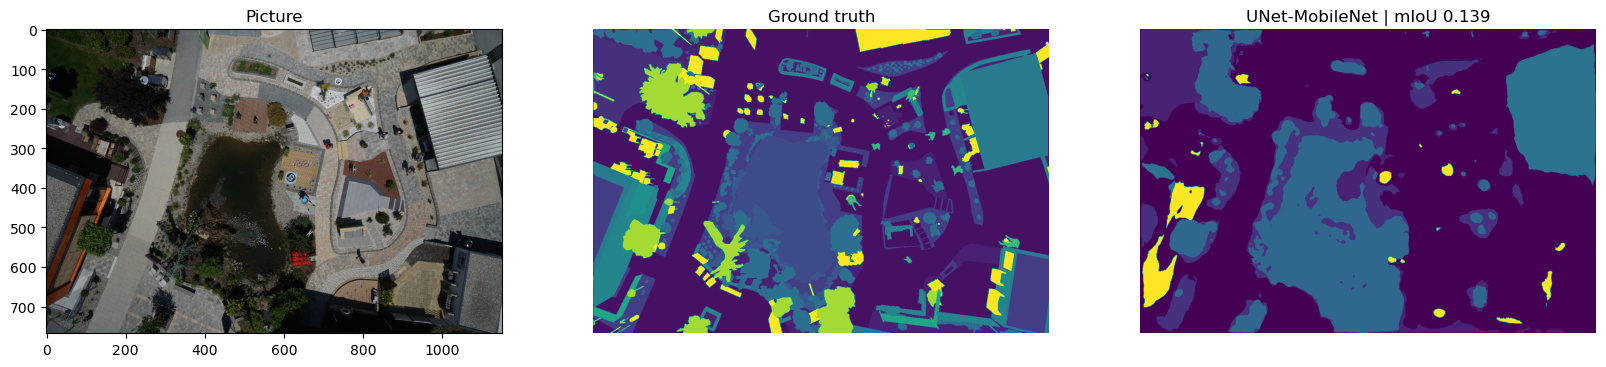

In [51]:
image3, mask3 = test_set[6]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

In [52]:
print('Test Set mIoU', np.mean(mob_miou))

Test Set mIoU 0.1993312978309124


In [53]:
print('Test Set Pixel Accuracy', np.mean(mob_acc))

Test Set Pixel Accuracy 0.7210047686541522
